In [1]:
#Cargamos librerías principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar librería para Profiling
%pip install ydata-profiling

# Perfilado de datos
from ydata_profiling import ProfileReport  # pyright: ignore[reportMissingImports]

In [2]:
pd.options.display.float_format = '{:.3f}'.format

# **_#1 Preparación de los datos_**

- Primero, al tener varias fuentes de datos, debemos unificarlas todas en un mismo dataframe.
- Recordemos que tenemos dos fuentes principales, los datos de los paneles solares (inversores) de donde vamos a extraer la variable objetivo, y los datos del sensor meteorologico de donde vamos a extraer las variables predictoras.

- Solo contamos con registros de julio y agosto. Para poder unir las fechas correctamente, lo que hicimos fue convertir todas las fechas a UTC-05:00 para que todas las fechas estén en el mismo timezone Colombiano.


In [3]:
# Cargamos los datos

fronius_inverter_july = pd.read_excel("etfroniusinverter_2025-07-01_a_2025-07-31_Sin_resolución_(original) (1).xlsx")
fronius_inverter_august = pd.read_excel("etfroniusinverter_2025-08-01_a_2025-08-10_Sin_resolución_(original).xlsx")

fronius_sensors_july = pd.read_excel("etfroniussensorcard_2025-07-01_a_2025-07-31_Sin_resolución_(original).xlsx")
fronius_sensors_august = pd.read_excel("etfroniussensorcard_2025-08-01_a_2025-08-10_Sin_resolución_(original).xlsx")

station_sensors = pd.read_excel("Bases de datos - prediccion de energía solar.xlsx", sheet_name="Estación Metereologica Ecovilla")

# Start of AI Agent code proposal
# Helper function to convert datetime columns from Colombia timezone (UTC-05:00) to UTC
def convert_to_utc(df, column_name):
    """Convert datetime column from Colombia timezone to UTC"""
    df[column_name] = pd.to_datetime(df[column_name])
    if df[column_name].dt.tz is None:
        df[column_name] = df[column_name].dt.tz_localize('America/Bogota')
    df[column_name] = df[column_name].dt.tz_convert('UTC-05:00')
    return df

# Convert all time columns to UTC
station_sensors = convert_to_utc(station_sensors, "Date")
fronius_inverter_july = convert_to_utc(fronius_inverter_july, "time_index_colombia")
fronius_inverter_august = convert_to_utc(fronius_inverter_august, "time_index_colombia")
fronius_sensors_july = convert_to_utc(fronius_sensors_july, "time_index_colombia")
fronius_sensors_august = convert_to_utc(fronius_sensors_august, "time_index_colombia")

# End of AI Agent code proposal

### Nota importante: En la EcoVilla nos advirtieron que en la ventana de tiempo que tomaron los datos, los inversores fronius de 45kw con IDs 1 y 2 estaban malos, por tanto los debemos sacar del ejercicio.


In [4]:
entities_to_drop = ["fronius_plant_45kWinverter1", "fronius_plant_45kWinverter2"]
fronius_inverter_july = fronius_inverter_july[~fronius_inverter_july["entity_id"].isin(entities_to_drop)]
fronius_inverter_august = fronius_inverter_august[~fronius_inverter_august["entity_id"].isin(entities_to_drop)]

##### Es necesario conocer los timeframes de cada dataset cargado para poder unificarlos en un mismo dataframe.


In [5]:
print("Min Max Fronius Inverter Julio: ", fronius_inverter_july["time_index_colombia"].min(), fronius_inverter_july["time_index_colombia"].max())
print("Min Max Fronius Inverter Agosto: ", fronius_inverter_august["time_index_colombia"].min(), fronius_inverter_august["time_index_colombia"].max())
print("Min Max Fronius Sensores Julio: ", fronius_sensors_july["time_index_colombia"].min(), fronius_sensors_july["time_index_colombia"].max())
print("Min Max Fronius Sensores Agosto: ", fronius_sensors_august["time_index_colombia"].min(), fronius_sensors_august["time_index_colombia"].max())
print("Min Max Estacion: ", station_sensors["Date"].min(), station_sensors["Date"].max())


Min Max Fronius Inverter Julio:  2025-07-08 10:00:47.590000-05:00 2025-07-31 18:47:23.512000-05:00
Min Max Fronius Inverter Agosto:  2025-07-31 20:13:25.135000-05:00 2025-08-10 18:36:17.876000-05:00
Min Max Fronius Sensores Julio:  2025-07-11 09:56:36.980000-05:00 2025-07-31 18:36:20.764000-05:00
Min Max Fronius Sensores Agosto:  2025-07-31 21:36:16.438000-05:00 2025-08-10 18:36:30.720000-05:00
Min Max Estacion:  2025-07-01 00:04:00-05:00 2025-08-11 23:56:00-05:00


##### Ahora que conocemos los timeframes, escogimos el rango de fechas que vamos a utilizar para el análisis, siendo desde 2025-07-11 hasta 2025-08-10.


In [6]:
# Start of AI Agent code proposal
# Filter all datasets to keep only rows in the date range 2025-07-11 to 2025-08-10
# Create date range in the same timezone as the data (UTC-05:00)
start_date = pd.to_datetime('2025-07-11').tz_localize('America/Bogota')
end_date = pd.to_datetime('2025-08-10 23:59:59').tz_localize('America/Bogota')

# Filter station_sensors
station_sensors = station_sensors[(station_sensors['Date'] >= start_date) & (station_sensors['Date'] <= end_date)]

# Filter Fronius datasets
fronius_inverter_july = fronius_inverter_july[(fronius_inverter_july['time_index_colombia'] >= start_date) & (fronius_inverter_july['time_index_colombia'] <= end_date)]
fronius_inverter_august = fronius_inverter_august[(fronius_inverter_august['time_index_colombia'] >= start_date) & (fronius_inverter_august['time_index_colombia'] <= end_date)]
fronius_sensors_july = fronius_sensors_july[(fronius_sensors_july['time_index_colombia'] >= start_date) & (fronius_sensors_july['time_index_colombia'] <= end_date)]
fronius_sensors_august = fronius_sensors_august[(fronius_sensors_august['time_index_colombia'] >= start_date) & (fronius_sensors_august['time_index_colombia'] <= end_date)]
# End of AI Agent code proposal

In [7]:
print("Min Max Fronius Inverter Julio: ", fronius_inverter_july["time_index_colombia"].min(), fronius_inverter_july["time_index_colombia"].max())
print("Min Max Fronius Inverter Agosto: ", fronius_inverter_august["time_index_colombia"].min(), fronius_inverter_august["time_index_colombia"].max())
print("Min Max Fronius Sensores Julio: ", fronius_sensors_july["time_index_colombia"].min(), fronius_sensors_july["time_index_colombia"].max())
print("Min Max Fronius Sensores Agosto: ", fronius_sensors_august["time_index_colombia"].min(), fronius_sensors_august["time_index_colombia"].max())
print("Min Max Estacion: ", station_sensors["Date"].min(), station_sensors["Date"].max())

Min Max Fronius Inverter Julio:  2025-07-11 00:20:55.087000-05:00 2025-07-31 18:47:23.512000-05:00
Min Max Fronius Inverter Agosto:  2025-07-31 20:13:25.135000-05:00 2025-08-10 18:36:17.876000-05:00
Min Max Fronius Sensores Julio:  2025-07-11 09:56:36.980000-05:00 2025-07-31 18:36:20.764000-05:00
Min Max Fronius Sensores Agosto:  2025-07-31 21:36:16.438000-05:00 2025-08-10 18:36:30.720000-05:00
Min Max Estacion:  2025-07-11 00:00:00-05:00 2025-08-10 23:55:00-05:00


#### Juntando los datos.


In [8]:
fronius_inverters_data = pd.concat([fronius_inverter_july, fronius_inverter_august]) # Dataset con variable objetivo
fronius_sensors_data = pd.concat([fronius_sensors_july, fronius_sensors_august]) # Dataset con variables predictoras


In [9]:
target_data = fronius_inverters_data[["time_index_colombia", "energyproducedtoday", "entity_id"]]

In [10]:
# Agrupando los datos de la variable predictora por el dia

# Start of AI Agent code proposal
# Group target_data by day and entity_id, getting the max energyproducedtoday for each day-entity_id combination
target_data_grouped = target_data.copy()

# Extract date part (without time) from the datetime column
target_data_grouped['date_only'] = target_data_grouped['time_index_colombia'].dt.date

# Group by date and entity_id, and get the max energyproducedtoday
target_data_grouped = target_data_grouped.groupby(['date_only', 'entity_id']).agg({
    'energyproducedtoday': 'max',
    'time_index_colombia': 'last'  # Keep the last datetime value for reference
}).reset_index()

target_data_grouped.drop('date_only', axis=1, inplace=True)

# End of AI Agent code proposal

In [11]:
## Separando los registros entre inversores de 45kw y 52kw
target_data_42kw = target_data_grouped[target_data_grouped["entity_id"].isin(["fronius_plant_45kWinverter3", "fronius_plant_45kWinverter4"])]
target_data_52kw = target_data_grouped[target_data_grouped["entity_id"].isin(["fronius_plant_52kWpinverter1", "fronius_plant_52kWpinverter2"])]

# target_data_42kw = target_data_hourly[target_data_hourly["entity_id"].isin(["fronius_plant_45kWinverter3", "fronius_plant_45kWinverter4"])]
# target_data_52kw = target_data_hourly[target_data_hourly["entity_id"].isin(["fronius_plant_52kWpinverter1", "fronius_plant_52kWpinverter2"])]

In [12]:
def group_and_average_daily(df, group_name):
    # Extract date part (without time) from the datetime column
    df['date_only'] = df['time_index_colombia'].dt.date

    # Group by date and entity_id, and get the max energyproducedtoday
    df_grouped = df.groupby(['date_only']).agg({
        'energyproducedtoday': 'mean',
        'time_index_colombia': 'last'  # Keep the last datetime value for reference
    }).reset_index()

    df_grouped.drop('date_only', axis=1, inplace=True)

    df_grouped["capacity"] = group_name

    return df_grouped

target_data_42kw = group_and_average_daily(target_data_42kw, "45kw")
target_data_52kw = group_and_average_daily(target_data_52kw, "52kw")

target_data_grouped = pd.concat([target_data_42kw, target_data_52kw])

/tmp/ipython-input-1853448389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_only'] = df['time_index_colombia'].dt.date
/tmp/ipython-input-1853448389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_only'] = df['time_index_colombia'].dt.date


In [13]:
target_data_grouped.shape

(58, 3)

#### Es importante aclarar que como los datos tanto de los sensores como de los inversores son tomados en lapsos de tiempo distintos, lo que hicimos fue agrupar los datos por dia y obtener el maximo y el minimo de cada dia para cada variable. Asi aseguramos que vamos a tener el mismo numero de datos para cada dia (1 dato por dia).


In [14]:
def process_predictors(df, date_column):
    """
    Process a dataset by grouping rows by the same day and calculating the maximum and minimum for each day.
    """
    # Create a copy to avoid modifying the original
    df_processed = df.copy()

    # Extract date part (without time) from the datetime column
    df_processed['date_only'] = df_processed[date_column].dt.date

    # Identify numeric columns (exclude the date_only column we just created)
    numeric_cols = [col for col in df_processed.select_dtypes(include=[np.number]).columns.tolist() if col != 'date_only']

    # Create aggregation dictionary for max and min values
    agg_dict = {
        # date_column: "first"
    }
    for col in numeric_cols:
        agg_dict[col + '_max'] = (col, 'max')
        agg_dict[col + '_min'] = (col, 'min')

    if date_column in df_processed.columns:
        agg_dict[date_column] = (date_column, 'first')  # Keep the first datetime value for reference

    # Group by date and aggregate max/min
    grouped = df_processed.groupby('date_only').agg(**agg_dict).reset_index(drop=True)

    # Remove the temporary date_only column if it exists in the result
    if 'date_only' in grouped.columns:
        grouped = grouped.drop(['date_only'], axis=1)

    return grouped

# Process the datasets using the function
station_sensors_grouped = process_predictors(station_sensors, "Date")
fronius_sensors_data_grouped = process_predictors(fronius_sensors_data, "time_index_colombia")

In [15]:
fronius_sensors_data_grouped

,paneltemperature_max,paneltemperature_min,ambienttemperature_max,ambienttemperature_min,solarirradiation_max,solarirradiation_min,time_index_colombia
0,52,24,35,24,782,0,2025-07-11 11:03:58.966000-05:00
1,59,17,37,20,907,0,2025-07-12 05:31:58.705000-05:00
2,41,21,33,23,477,0,2025-07-14 15:45:49.734000-05:00
3,59,19,39,21,927,0,2025-07-15 06:00:10.750000-05:00
4,58,19,39,21,947,0,2025-07-16 06:48:43.956000-05:00
5,58,19,38,21,1049,0,2025-07-17 06:49:41.575000-05:00
6,56,17,37,20,1086,0,2025-07-18 05:39:46.600000-05:00
7,58,20,38,21,1048,0,2025-07-19 05:49:44.187000-05:00
8,60,17,39,20,1042,0,2025-07-20 06:07:13.725000-05:00
9,52,19,34,21,1016,0,2025-07-21 05:46:44.683000-05:00


In [16]:
print("# Registros Sensores EcoVilla (Predictoras)", station_sensors_grouped.shape[0])
print("# Registros Sensores Fronius (Predictoras)", fronius_sensors_data_grouped.shape[0])
print("# Registros Inversores (Objetivo)", target_data_grouped.shape[0])

# Registros Sensores EcoVilla (Predictoras) 31
# Registros Sensores Fronius (Predictoras) 22
# Registros Inversores (Objetivo) 58


#### Como tenemos tan pocos datos de los sensores Fronius, decidimos no disponer de estos datos. Al tomar esta decision estamos perdiendo 3 variables predictoras: Temperatura del panel, Temperatura ambiente, Radiacion Solar.

#### Se hace esta anotacion porque estas variables posiblemente pueden tener correlacion con la variable objetivo, asi que para un proximo ejercicio nos podria ser util tener estos datos.


In [17]:
# Preparando las variables predictoras
station_sensors_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 45 columns):
 #   Column                                       Non-Null Count  Dtype                    
---  ------                                       --------------  -----                    
 0   Outdoor Temperature (Â°C)_max                31 non-null     float64                  
 1   Outdoor Temperature (Â°C)_min                31 non-null     float64                  
 2   Feels Like (Â°C)_max                         31 non-null     float64                  
 3   Feels Like (Â°C)_min                         31 non-null     float64                  
 4   Dew Point (Â°C)_max                          31 non-null     float64                  
 5   Dew Point (Â°C)_min                          31 non-null     float64                  
 6   Wind Speed (m/sec)_max                       31 non-null     float64                  
 7   Wind Speed (m/sec)_min                       31 non-null     flo

In [18]:
# Las variables "PM2.5 Outdoor" y "PM2.5 Outdoor 24 Hour Average" no las usamos en el modelo puesto que no tenemos informacion.
cols_to_drop = [
    "PM2.5 Outdoor (Âµg/m^3)_max",
    "PM2.5 Outdoor (Âµg/m^3)_min",
    "PM2.5 Outdoor 24 Hour Average (Âµg/m^3)_max",
    "PM2.5 Outdoor 24 Hour Average (Âµg/m^3)_min"
]
station_sensors_grouped = station_sensors_grouped.drop(columns=cols_to_drop)
station_sensors_grouped.head()

,Outdoor Temperature (Â°C)_max,Outdoor Temperature (Â°C)_min,Feels Like (Â°C)_max,Feels Like (Â°C)_min,Dew Point (Â°C)_max,Dew Point (Â°C)_min,Wind Speed (m/sec)_max,Wind Speed (m/sec)_min,Wind Gust (m/sec)_max,Wind Gust (m/sec)_min,...,Solar Radiation (W/m^2)_min,Indoor Temperature (Â°C)_max,Indoor Temperature (Â°C)_min,Indoor Humidity (%)_max,Indoor Humidity (%)_min,Avg Wind Direction (10 mins) (Â°)_max,Avg Wind Direction (10 mins) (Â°)_min,Absolute Pressure (mmHg)_max,Absolute Pressure (mmHg)_min,Date
0,30.200,18.200,30.500,18.200,19.100,14.400,2.900,0.000,4.600,0.000,...,0.000,29.200,22.600,72,53,142.000,22.000,643.400,639.600,2025-07-11 23:55:00-05:00
1,31.400,17.100,31.400,17.100,18.700,14.400,3.500,0.000,5.100,0.000,...,0.000,31.400,22.900,70,48,297.000,9.000,643.400,639.700,2025-07-12 23:55:00-05:00
2,30.200,18.500,30.900,18.500,19.100,15.000,2.600,0.000,4.100,0.000,...,0.000,30.900,23.500,67,50,146.000,12.000,643.300,640.300,2025-07-13 23:55:00-05:00
3,30.600,18.100,30.400,18.100,18.300,14.300,3.200,0.000,4.600,0.000,...,0.000,30.500,23.700,68,41,165.000,12.000,643.800,640.100,2025-07-14 23:55:00-05:00
4,32.900,16.800,32.800,16.800,18.100,13.600,2.800,0.000,4.600,0.000,...,0.000,28.600,23.000,64,38,167.000,14.000,642.600,639.100,2025-07-15 23:57:00-05:00


In [19]:
station_sensors_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype                    
---  ------                                 --------------  -----                    
 0   Outdoor Temperature (Â°C)_max          31 non-null     float64                  
 1   Outdoor Temperature (Â°C)_min          31 non-null     float64                  
 2   Feels Like (Â°C)_max                   31 non-null     float64                  
 3   Feels Like (Â°C)_min                   31 non-null     float64                  
 4   Dew Point (Â°C)_max                    31 non-null     float64                  
 5   Dew Point (Â°C)_min                    31 non-null     float64                  
 6   Wind Speed (m/sec)_max                 31 non-null     float64                  
 7   Wind Speed (m/sec)_min                 31 non-null     float64                  
 8   Wind Gust (m/sec)_max           

#### Juntando el dataset de variables predictoras con el dataset de la variable objetivo.


In [20]:
station_sensors_grouped["date"] = station_sensors_grouped["Date"].dt.date
target_data_grouped["date"] = target_data_grouped["time_index_colombia"].dt.date

merged_df = pd.merge(target_data_grouped, station_sensors_grouped, on="date", how="inner")
merged_df.head()

,energyproducedtoday,time_index_colombia,capacity,date,Outdoor Temperature (Â°C)_max,Outdoor Temperature (Â°C)_min,Feels Like (Â°C)_max,Feels Like (Â°C)_min,Dew Point (Â°C)_max,Dew Point (Â°C)_min,...,Solar Radiation (W/m^2)_min,Indoor Temperature (Â°C)_max,Indoor Temperature (Â°C)_min,Indoor Humidity (%)_max,Indoor Humidity (%)_min,Avg Wind Direction (10 mins) (Â°)_max,Avg Wind Direction (10 mins) (Â°)_min,Absolute Pressure (mmHg)_max,Absolute Pressure (mmHg)_min,Date
0,29500.000,2025-07-11 18:07:20.841000-05:00,45kw,2025-07-11,30.200,18.200,30.500,18.200,19.100,14.400,...,0.000,29.200,22.600,72,53,142.000,22.000,643.400,639.600,2025-07-11 23:55:00-05:00
1,33000.000,2025-07-12 17:12:37.933000-05:00,45kw,2025-07-12,31.400,17.100,31.400,17.100,18.700,14.400,...,0.000,31.400,22.900,70,48,297.000,9.000,643.400,639.700,2025-07-12 23:55:00-05:00
2,33500.000,2025-07-14 18:27:36.251000-05:00,45kw,2025-07-14,30.600,18.100,30.400,18.100,18.300,14.300,...,0.000,30.500,23.700,68,41,165.000,12.000,643.800,640.100,2025-07-14 23:55:00-05:00
3,39000.000,2025-07-15 18:17:52.003000-05:00,45kw,2025-07-15,32.900,16.800,32.800,16.800,18.100,13.600,...,0.000,28.600,23.000,64,38,167.000,14.000,642.600,639.100,2025-07-15 23:57:00-05:00
4,40000.000,2025-07-16 18:25:13.344000-05:00,45kw,2025-07-16,32.400,19.100,32.000,19.100,16.700,13.700,...,0.000,34.100,23.700,58,39,357.000,31.000,642.300,638.800,2025-07-16 23:58:00-05:00


In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 45 columns):
 #   Column                                 Non-Null Count  Dtype                    
---  ------                                 --------------  -----                    
 0   energyproducedtoday                    58 non-null     float64                  
 1   time_index_colombia                    58 non-null     datetime64[ns, UTC-05:00]
 2   capacity                               58 non-null     object                   
 3   date                                   58 non-null     object                   
 4   Outdoor Temperature (Â°C)_max          58 non-null     float64                  
 5   Outdoor Temperature (Â°C)_min          58 non-null     float64                  
 6   Feels Like (Â°C)_max                   58 non-null     float64                  
 7   Feels Like (Â°C)_min                   58 non-null     float64                  
 8   Dew Point (Â°C)_max             

In [22]:
# Eliminando variables irrelevantes.
cols_to_drop = ["time_index_colombia", "date", "Date"]
df = merged_df.drop(columns=cols_to_drop)
df.head()

,energyproducedtoday,capacity,Outdoor Temperature (Â°C)_max,Outdoor Temperature (Â°C)_min,Feels Like (Â°C)_max,Feels Like (Â°C)_min,Dew Point (Â°C)_max,Dew Point (Â°C)_min,Wind Speed (m/sec)_max,Wind Speed (m/sec)_min,...,Solar Radiation (W/m^2)_max,Solar Radiation (W/m^2)_min,Indoor Temperature (Â°C)_max,Indoor Temperature (Â°C)_min,Indoor Humidity (%)_max,Indoor Humidity (%)_min,Avg Wind Direction (10 mins) (Â°)_max,Avg Wind Direction (10 mins) (Â°)_min,Absolute Pressure (mmHg)_max,Absolute Pressure (mmHg)_min
0,29500.000,45kw,30.200,18.200,30.500,18.200,19.100,14.400,2.900,0.000,...,576.900,0.000,29.200,22.600,72,53,142.000,22.000,643.400,639.600
1,33000.000,45kw,31.400,17.100,31.400,17.100,18.700,14.400,3.500,0.000,...,667.700,0.000,31.400,22.900,70,48,297.000,9.000,643.400,639.700
2,33500.000,45kw,30.600,18.100,30.400,18.100,18.300,14.300,3.200,0.000,...,788.000,0.000,30.500,23.700,68,41,165.000,12.000,643.800,640.100
3,39000.000,45kw,32.900,16.800,32.800,16.800,18.100,13.600,2.800,0.000,...,707.100,0.000,28.600,23.000,64,38,167.000,14.000,642.600,639.100
4,40000.000,45kw,32.400,19.100,32.000,19.100,16.700,13.700,3.300,0.000,...,710.700,0.000,34.100,23.700,58,39,357.000,31.000,642.300,638.800


In [82]:
pd.set_option('display.max_columns', None)
df.head(1)  # Muestra la primera fila con todas las columnas

,energyproducedtoday,Outdoor Temperature (Â°C)_max,Outdoor Temperature (Â°C)_min,Feels Like (Â°C)_max,Feels Like (Â°C)_min,Dew Point (Â°C)_max,Dew Point (Â°C)_min,Wind Speed (m/sec)_max,Wind Gust (m/sec)_max,Max Daily Gust (m/sec)_max,Wind Direction (Â°)_max,Wind Direction (Â°)_min,Rain Rate (mm/hr)_max,Daily Rain (mm)_max,Weekly Rain (mm)_max,Weekly Rain (mm)_min,Yearly Rain (mm)_max,Yearly Rain (mm)_min,Humidity (%)_min,Ultra-Violet Radiation Index_max,Solar Radiation (W/m^2)_max,Indoor Temperature (Â°C)_max,Indoor Temperature (Â°C)_min,Indoor Humidity (%)_max,Indoor Humidity (%)_min,Avg Wind Direction (10 mins) (Â°)_min,capacity_45kw,capacity_52kw
0,29500.00,30.20,18.20,30.50,18.20,19.10,14.40,2.90,4.60,5.60,338.00,7.00,21.00,5.30,9.40,4.10,1379.10,1373.80,44.00,5.00,576.90,29.20,22.60,72,53,22.00,1,0


# #2 Entendimiento de los datos y estadistica descriptiva


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   energyproducedtoday                    58 non-null     float64
 1   capacity                               58 non-null     object 
 2   Outdoor Temperature (Â°C)_max          58 non-null     float64
 3   Outdoor Temperature (Â°C)_min          58 non-null     float64
 4   Feels Like (Â°C)_max                   58 non-null     float64
 5   Feels Like (Â°C)_min                   58 non-null     float64
 6   Dew Point (Â°C)_max                    58 non-null     float64
 7   Dew Point (Â°C)_min                    58 non-null     float64
 8   Wind Speed (m/sec)_max                 58 non-null     float64
 9   Wind Speed (m/sec)_min                 58 non-null     float64
 10  Wind Gust (m/sec)_max                  58 non-null     float64
 11  Wind Gus

In [24]:
df["capacity"] = df["capacity"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   energyproducedtoday                    58 non-null     float64 
 1   capacity                               58 non-null     category
 2   Outdoor Temperature (Â°C)_max          58 non-null     float64 
 3   Outdoor Temperature (Â°C)_min          58 non-null     float64 
 4   Feels Like (Â°C)_max                   58 non-null     float64 
 5   Feels Like (Â°C)_min                   58 non-null     float64 
 6   Dew Point (Â°C)_max                    58 non-null     float64 
 7   Dew Point (Â°C)_min                    58 non-null     float64 
 8   Wind Speed (m/sec)_max                 58 non-null     float64 
 9   Wind Speed (m/sec)_min                 58 non-null     float64 
 10  Wind Gust (m/sec)_max                  58 non-null     float64 


In [25]:
df.describe()

,energyproducedtoday,Outdoor Temperature (Â°C)_max,Outdoor Temperature (Â°C)_min,Feels Like (Â°C)_max,Feels Like (Â°C)_min,Dew Point (Â°C)_max,Dew Point (Â°C)_min,Wind Speed (m/sec)_max,Wind Speed (m/sec)_min,Wind Gust (m/sec)_max,...,Solar Radiation (W/m^2)_max,Solar Radiation (W/m^2)_min,Indoor Temperature (Â°C)_max,Indoor Temperature (Â°C)_min,Indoor Humidity (%)_max,Indoor Humidity (%)_min,Avg Wind Direction (10 mins) (Â°)_max,Avg Wind Direction (10 mins) (Â°)_min,Absolute Pressure (mmHg)_max,Absolute Pressure (mmHg)_min
count,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000,...,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000
mean,69965.832,30.797,17.624,30.786,17.634,18.728,13.652,2.979,0.000,4.928,...,738.772,0.000,30.117,23.028,66.034,43.828,208.966,19.828,643.197,639.441
std,43543.799,1.784,1.338,1.610,1.359,0.930,1.621,0.463,0.000,0.830,...,92.922,0.000,2.037,1.066,6.327,7.356,70.758,15.877,0.732,0.742
min,3.250,25.400,15.400,25.500,15.400,16.700,6.900,2.000,0.000,3.600,...,486.300,0.000,26.800,20.700,53.000,31.000,142.000,0.000,641.900,638.100
25%,33000.000,30.300,16.800,29.900,16.800,18.100,13.000,2.700,0.000,4.100,...,707.100,0.000,28.800,22.300,62.000,39.000,159.000,10.000,642.600,639.000
50%,41000.000,30.600,17.100,31.100,17.100,18.800,13.800,2.900,0.000,4.600,...,749.200,0.000,29.900,23.400,67.000,41.000,182.000,14.000,643.300,639.400
75%,113031.250,32.400,18.900,32.000,18.900,19.200,14.400,3.300,0.000,5.600,...,802.000,0.000,31.300,23.800,70.000,48.000,279.000,26.000,643.500,639.900
max,149695.000,33.200,20.100,33.000,20.400,20.800,15.900,4.100,0.000,6.600,...,887.500,0.000,34.100,24.400,78.000,62.000,357.000,72.000,645.000,641.100


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [26]:
profile_data=ProfileReport(df, minimal=False)
profile_data.to_file(output_file="profiling-ecovilla.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 42/42 [00:00<00:00, 80.32it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
df = pd.get_dummies(df, columns=["capacity"], drop_first=False, dtype=int)
df_correlations = df.corr()

In [28]:
def plot_correlation_heatmap(corr_matrix):
    %matplotlib inline
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f", linewidths=.25)
    plt.title('Correlation Matrix')
    plt.show()

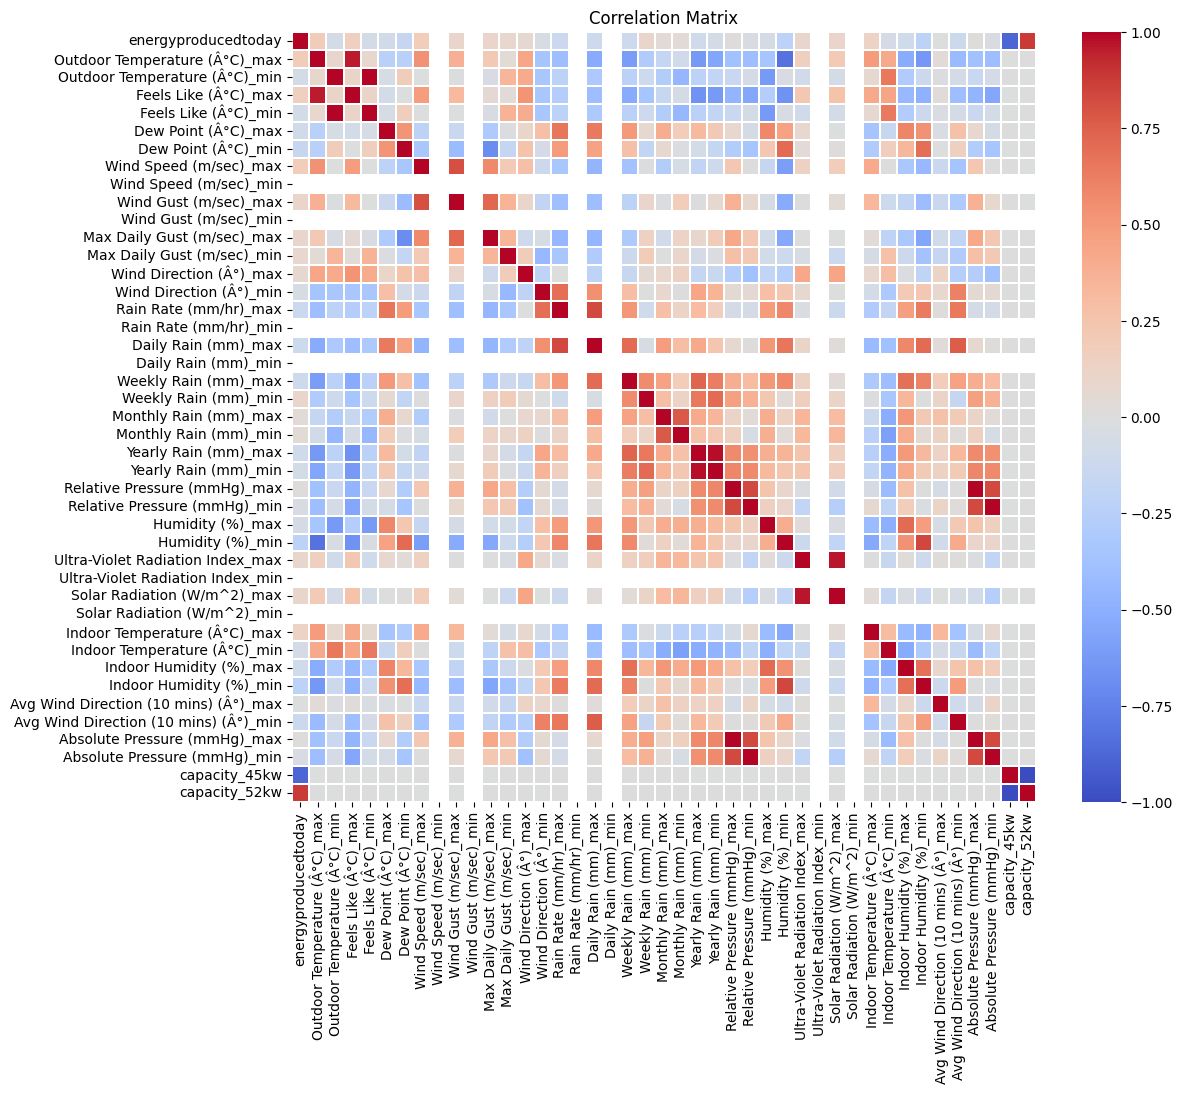

In [29]:
plot_correlation_heatmap(df_correlations)

### En vista de que claramente nos enfrentamos a un problema de alta dimensionalidad, cuyas correlaciones (lineales) son demasiadas entre las variables y muy distintas, nos enfocaremos solo en descartar las variables que no tienen correlacion (lineal y no lineal) con la variable objetivo, despues, de acuerdo a los modelos que escogimos para hacer la prediccion aplicaremos PCA para los que lo requieran.

### Para evaluar las correlaciones no lineales usaremos unicamente la correlacion de Spearman.

In [30]:
df_correlations["energyproducedtoday"].sort_values(ascending=False)

,energyproducedtoday
energyproducedtoday,1.000
capacity_52kw,0.879
Outdoor Temperature (Â°C)_max,0.190
Wind Speed (m/sec)_max,0.185
Feels Like (Â°C)_max,0.158
Indoor Temperature (Â°C)_max,0.128
Solar Radiation (W/m^2)_max,0.101
Wind Gust (m/sec)_max,0.101
Weekly Rain (mm)_min,0.097
Max Daily Gust (m/sec)_max,0.094


In [31]:
cols_to_drop = ["Wind Speed (m/sec)_min", "Wind Gust (m/sec)_min", "Rain Rate (mm/hr)_min", "Daily Rain (mm)_min", "Ultra-Violet Radiation Index_min", "Solar Radiation (W/m^2)_min"]

# Start of AI Agent code proposal

from scipy.stats import spearmanr

# Specify your target variable (replace 'target' with your target column name)
target = 'energyproducedtoday'
features = [col for col in df.columns if col != target]

# Calculate Spearman's correlation for each feature with the target
spearman_corr = []
for feature in features:
    corr, _ = spearmanr(df[feature], df[target])
    spearman_corr.append((feature, corr))
    if abs(corr) < 0.1: # Drop features with low correlation
        cols_to_drop.append(feature)

# Sort by absolute correlation value (descending)
spearman_corr_sorted = sorted(spearman_corr, key=lambda x: abs(x[1]), reverse=True)

# Print the ranked list
for rank, (feature, corr) in enumerate(spearman_corr_sorted, 1):
    print(f"{rank}. {feature}: {corr:.4f}")

# End of AI Agent code proposal

1. Wind Speed (m/sec)_min: nan
2. Wind Gust (m/sec)_min: nan
3. Rain Rate (mm/hr)_min: nan
4. Daily Rain (mm)_min: nan
5. Ultra-Violet Radiation Index_min: nan
6. Solar Radiation (W/m^2)_min: nan
7. capacity_45kw: -0.8067
8. capacity_52kw: 0.8067
9. Humidity (%)_min: -0.3844
10. Indoor Humidity (%)_min: -0.3634
11. Outdoor Temperature (Â°C)_max: 0.3086
12. Dew Point (Â°C)_min: -0.2952
13. Rain Rate (mm/hr)_max: -0.2732
14. Wind Speed (m/sec)_max: 0.2496
15. Daily Rain (mm)_max: -0.2355
16. Feels Like (Â°C)_max: 0.2340
17. Avg Wind Direction (10 mins) (Â°)_min: -0.2082
18. Indoor Temperature (Â°C)_max: 0.1977
19. Weekly Rain (mm)_min: 0.1936
20. Wind Gust (m/sec)_max: 0.1704
21. Indoor Humidity (%)_max: -0.1699
22. Wind Direction (Â°)_max: 0.1579
23. Weekly Rain (mm)_max: -0.1459
24. Dew Point (Â°C)_max: -0.1403
25. Yearly Rain (mm)_max: -0.1355
26. Max Daily Gust (m/sec)_max: 0.1353
27. Wind Direction (Â°)_min: -0.1154
28. Outdoor Temperature (Â°C)_min: -0.1143
29. Feels Like (Â°C)_min

/tmp/ipython-input-2559892599.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(df[feature], df[target])


In [32]:
cols_to_drop

['Wind Speed (m/sec)_min',
 'Wind Gust (m/sec)_min',
 'Rain Rate (mm/hr)_min',
 'Daily Rain (mm)_min',
 'Ultra-Violet Radiation Index_min',
 'Solar Radiation (W/m^2)_min',
 'Max Daily Gust (m/sec)_min',
 'Monthly Rain (mm)_max',
 'Monthly Rain (mm)_min',
 'Relative Pressure (mmHg)_max',
 'Relative Pressure (mmHg)_min',
 'Humidity (%)_max',
 'Avg Wind Direction (10 mins) (Â°)_max',
 'Absolute Pressure (mmHg)_max',
 'Absolute Pressure (mmHg)_min']

In [33]:
df = df.drop(columns=cols_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   energyproducedtoday                    58 non-null     float64
 1   Outdoor Temperature (Â°C)_max          58 non-null     float64
 2   Outdoor Temperature (Â°C)_min          58 non-null     float64
 3   Feels Like (Â°C)_max                   58 non-null     float64
 4   Feels Like (Â°C)_min                   58 non-null     float64
 5   Dew Point (Â°C)_max                    58 non-null     float64
 6   Dew Point (Â°C)_min                    58 non-null     float64
 7   Wind Speed (m/sec)_max                 58 non-null     float64
 8   Wind Gust (m/sec)_max                  58 non-null     float64
 9   Max Daily Gust (m/sec)_max             58 non-null     float64
 10  Wind Direction (Â°)_max                58 non-null     float64
 11  Wind Dir

### El resultado final termina siendo 27 variables predictoras y 1 variable objetivo.

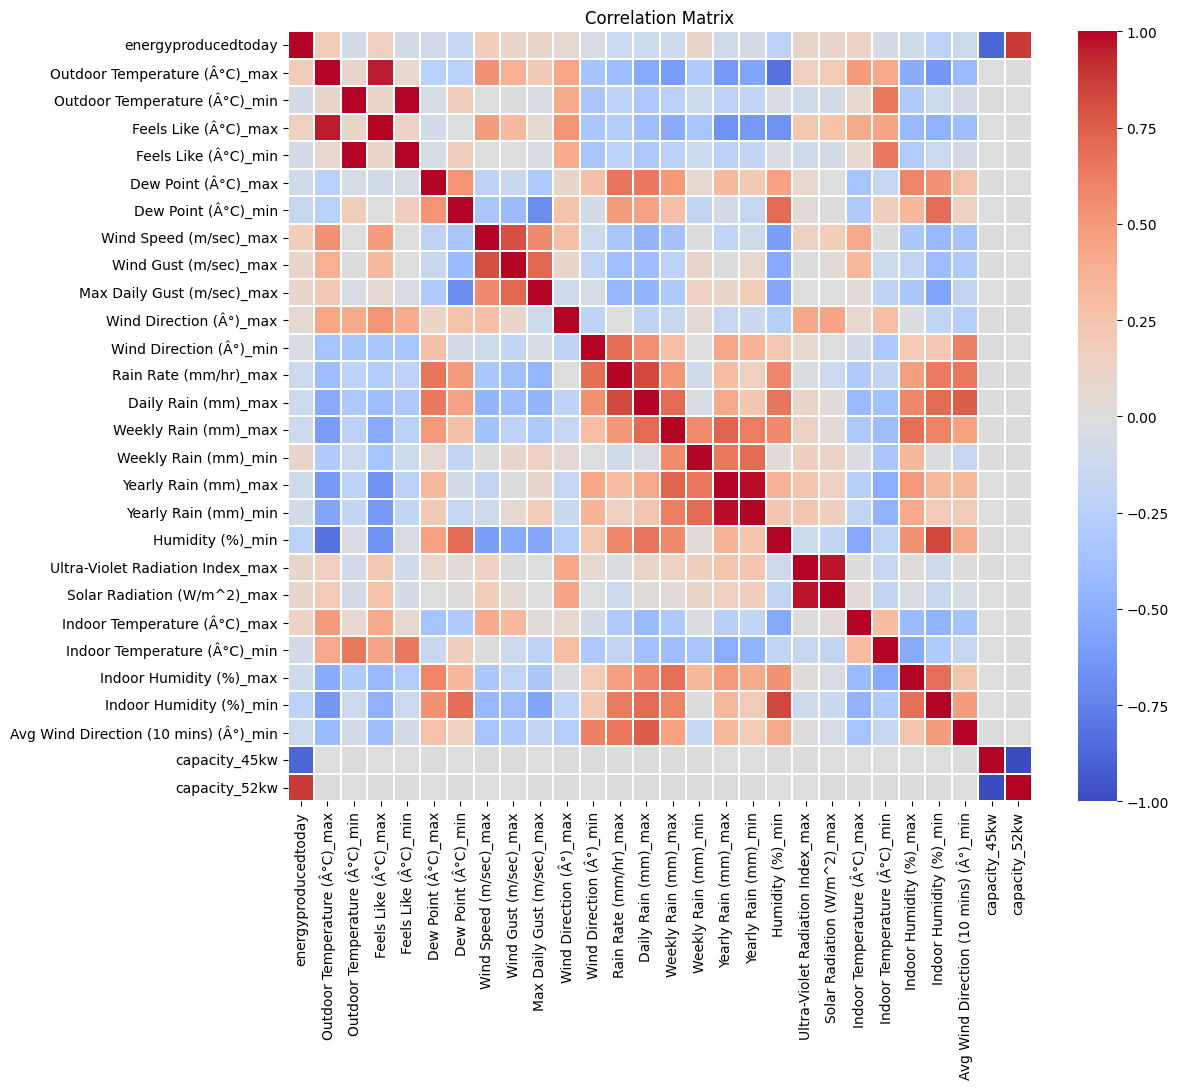

In [34]:
df_correlations = df.corr()
plot_correlation_heatmap(df_correlations)

## A partir de aqui, se procede con el entrenamiento de los modelos.

### Modelos que SI requieren reduccion de dimensionalidad:
- Regresion Lineal.
- KNN de Regresion.
- Arbol de Regresion.

### Modelos que NO requieren reduccion de dimensionalidad:
- Support Vector Regression.
- Redes Neuronales.
- XGBOOST.
- Random Forest Regression.

### Comenzamos creando los siguientes datasets:
- Normalizado y con PCA.
- Normalizado y sin PCA.
- Sin normalizar y con PCA.
- Sin normalizar y sin PCA.

# En este caso no haremos division 70-30 porque contamos con muy pocos datos.

In [35]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["energyproducedtoday"])
Y = df["energyproducedtoday"]

#X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(
 #   X, Y, test_size=0.3, random_state=42)

# Conjuntos con normalizacion y pca

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# --- Inicializamos escalador y PCA ---
scaler = MinMaxScaler()
pca = PCA(n_components=3)

# --- (1) Con normalización y con PCA ---
X_si_norm_si_PCA = pca.fit_transform(scaler.fit_transform(X))

# --- (2) Con normalización y sin PCA ---
X_si_norm_no_PCA = scaler.fit_transform(X)

# --- (3) Sin normalización y con PCA ---
X_no_norm_si_PCA = pca.fit_transform(X)

# --- (4) Sin normalización y sin PCA ---
X_no_norm_no_PCA = X.copy()

# Validación cruzada
Usamos cv = 3 por la cantidad limitada de datos. Se espera un comportamiento similar a usar una división 70-30 sin validación cruzada

In [37]:
#Validación Cruzada
from sklearn.model_selection import cross_validate

#Dataframe para comparar los modelos
comparacion_CV=pd.DataFrame()

#Medidas de evaluación
scoring=('neg_mean_absolute_error', 'neg_mean_squared_error','neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error')

#Muestreo lineal
cv=3

# DataFrame para comparar modelos
comparacion_CV = pd.DataFrame()

# 1. TREE

In [38]:
#Método de ML a usar en la validación cruzada
from sklearn import tree
modelTree = tree.DecisionTreeRegressor(criterion='squared_error', min_samples_leaf=7, max_depth=None)

# return train score, con True me devuelve medidas dde evaluación en el conjunto de entrenamiento
scores = cross_validate(modelTree, X_no_norm_si_PCA, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores=pd.DataFrame(scores) #Se almacenan los resultados en un dataframe
scores

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,0.002,0.004,-77363.768,-25040.708,-6188493323.102,-966557110.583,-78666.977,-31089.502,-2.339,-392.194
1,0.002,0.004,-66439.760,-29173.665,-4737875828.506,-1288709055.136,-68832.230,-35898.594,-9.638,-529.427
2,0.002,0.004,-72211.591,-24974.042,-5771398491.079,-1034038082.877,-75969.721,-32156.463,-439.471,-2.158


In [39]:
# Promedios para verificar overfitting comparando medidas en train y test
scores.mean()

#Cuidado overfitting, más de 5 puntos de diferencia

,0
fit_time,0.002
score_time,0.004
test_neg_mean_absolute_error,-72005.039
train_neg_mean_absolute_error,-26396.139
test_neg_mean_squared_error,-5565922547.562
train_neg_mean_squared_error,-1096434749.532
test_neg_root_mean_squared_error,-74489.643
train_neg_root_mean_squared_error,-33048.186
test_neg_mean_absolute_percentage_error,-150.483
train_neg_mean_absolute_percentage_error,-307.926


In [40]:
#Se almacena en el df la medida a comparar
comparacion_CV['Tree']=scores['test_neg_mean_absolute_error']
print(comparacion_CV)

        Tree
0 -77363.768
1 -66439.760
2 -72211.591


# 2. Random Forest

In [41]:
#Método de ML a usar en la validación cruzada
from sklearn import ensemble
modelRf = ensemble.RandomForestRegressor(n_estimators=200, max_samples=0.8, criterion='squared_error', min_samples_leaf=2, max_depth=None)


scores = cross_validate(modelRf, X_no_norm_no_PCA, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores=pd.DataFrame(scores) #Se almacenan los resultados en un dataframe
scores

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,0.467,0.031,-5424.250,-7881.605,-36063377.113,-191208668.227,-6005.279,-13827.822,-0.171,-536.714
1,0.440,0.032,-11010.071,-6466.685,-188197654.927,-165184757.121,-13718.515,-12852.422,-3.823,-532.518
2,0.494,0.031,-23703.339,-3486.329,-1197114075.957,-37783105.533,-34599.336,-6146.796,-1894.662,-1.417


In [42]:
# Promedios para verificar overfitting comparando medidas en train y test
scores.mean()
#Cuidado overfitting, más de 5 puntos de diferencia

,0
fit_time,0.467
score_time,0.031
test_neg_mean_absolute_error,-13379.220
train_neg_mean_absolute_error,-5944.873
test_neg_mean_squared_error,-473791702.666
train_neg_mean_squared_error,-131392176.960
test_neg_root_mean_squared_error,-18107.710
train_neg_root_mean_squared_error,-10942.347
test_neg_mean_absolute_percentage_error,-632.885
train_neg_mean_absolute_percentage_error,-356.883


In [43]:
#Se almacena en el df la medida a comparar
comparacion_CV['RF']=scores['test_neg_mean_absolute_error']
print(comparacion_CV)

        Tree         RF
0 -77363.768  -5424.250
1 -66439.760 -11010.071
2 -72211.591 -23703.339


# 3. KNN

In [44]:
#Método Perezoso
from sklearn.neighbors import KNeighborsRegressor
model_knn = KNeighborsRegressor(n_neighbors=3, metric='euclidean')


scores = cross_validate(model_knn, X_si_norm_si_PCA, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores=pd.DataFrame(scores) #Se almacenan los resultados en un dataframe

scores

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,0.007,0.008,-9029.333,-12527.226,-104063352.222,-290085839.609,-10201.145,-17031.907,-0.265,-483.203
1,0.002,0.005,-13789.917,-9024.462,-357408816.545,-226615082.930,-18905.259,-15053.740,-4.388,-548.097
2,0.002,0.007,-31468.075,-5827.991,-1988175071.097,-78416634.829,-44588.957,-8855.317,-1817.874,-1.239


In [45]:
# Promedios para verificar overfitting comparando medida de train y test
scores.mean()

,0
fit_time,0.003
score_time,0.007
test_neg_mean_absolute_error,-18095.775
train_neg_mean_absolute_error,-9126.560
test_neg_mean_squared_error,-816549079.955
train_neg_mean_squared_error,-198372519.123
test_neg_root_mean_squared_error,-24565.120
train_neg_root_mean_squared_error,-13646.988
test_neg_mean_absolute_percentage_error,-607.509
train_neg_mean_absolute_percentage_error,-344.180


In [46]:
#Se almacena en el df la medida a comparar
comparacion_CV['Knn']=scores['test_neg_mean_absolute_error']
print(comparacion_CV)

        Tree         RF        Knn
0 -77363.768  -5424.250  -9029.333
1 -66439.760 -11010.071 -13789.917
2 -72211.591 -23703.339 -31468.075


# 4. Red Neuronal

In [47]:
#Red neuronal
from sklearn.neural_network import MLPRegressor
model_rn = MLPRegressor(activation="relu",hidden_layer_sizes=(200), learning_rate='adaptive',
                     learning_rate_init=0.7, momentum= 0.3, max_iter=500, verbose=False)

scores = cross_validate(model_rn, X_si_norm_no_PCA, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores=pd.DataFrame(scores) #Se almacenan los resultados en un dataframe

scores

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,0.528,0.004,-9723.378,-5034.953,-140881927.982,-42731830.514,-11869.369,-6536.959,-0.298,-74.114
1,0.295,0.003,-11585.594,-2936.408,-206298240.681,-15395743.935,-14363.086,-3923.741,-0.251,-65.601
2,0.282,0.003,-17723.293,-2842.242,-597755348.379,-24613252.558,-24449.036,-4961.175,-1152.212,-0.343


In [48]:
# Promedios para verificar overfitting comparando medida de train y test
scores.mean()

,0
fit_time,0.368
score_time,0.004
test_neg_mean_absolute_error,-13010.755
train_neg_mean_absolute_error,-3604.534
test_neg_mean_squared_error,-314978505.681
train_neg_mean_squared_error,-27580275.669
test_neg_root_mean_squared_error,-16893.830
train_neg_root_mean_squared_error,-5140.625
test_neg_mean_absolute_percentage_error,-384.254
train_neg_mean_absolute_percentage_error,-46.686


In [49]:
#Se almacena en el df la medida a comparar
comparacion_CV['Nn']=scores['test_neg_mean_absolute_error']
print(comparacion_CV)

        Tree         RF        Knn         Nn
0 -77363.768  -5424.250  -9029.333  -9723.378
1 -66439.760 -11010.071 -13789.917 -11585.594
2 -72211.591 -23703.339 -31468.075 -17723.293


# 5. Support Vector Regression


In [50]:
from sklearn.svm import SVR

# Inicializando y entrenando el modelo SVR
model_svm = SVR(kernel='rbf', C=1.0, epsilon=0.1) # Example parameters

scores = cross_validate(model_svm, X_si_norm_no_PCA, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores=pd.DataFrame(scores) #Se almacenan los resultados en un dataframe

scores

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,0.002,0.005,-69927.660,-33641.168,-4908379903.465,-1961958059.825,-70059.831,-44293.996,-2.149,-844.057
1,0.003,0.003,-45519.958,-36439.179,-3361939916.650,-2558419696.509,-57982.238,-50580.823,-5.403,-308.130
2,0.002,0.003,-71512.505,-24418.989,-5597616397.119,-1759502198.356,-74817.220,-41946.421,-583.602,-2.503


In [51]:
# Promedios para verificar overfitting comparando medida de train y test
scores.mean()

,0
fit_time,0.002
score_time,0.004
test_neg_mean_absolute_error,-62320.041
train_neg_mean_absolute_error,-31499.778
test_neg_mean_squared_error,-4622645405.745
train_neg_mean_squared_error,-2093293318.230
test_neg_root_mean_squared_error,-67619.763
train_neg_root_mean_squared_error,-45607.080
test_neg_mean_absolute_percentage_error,-197.051
train_neg_mean_absolute_percentage_error,-384.897


In [52]:
#Se almacena en el df la medida a comparar
comparacion_CV['SVM']=scores['test_neg_mean_absolute_error']
print(comparacion_CV)

        Tree         RF        Knn         Nn        SVM
0 -77363.768  -5424.250  -9029.333  -9723.378 -69927.660
1 -66439.760 -11010.071 -13789.917 -11585.594 -45519.958
2 -72211.591 -23703.339 -31468.075 -17723.293 -71512.505


# 6. XGBOOST

In [53]:
# !brew install libomp
%pip install xgboost

In [54]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(objective='reg:squarederror',  # Specify objective for regression
                             n_estimators=100,             # Number of boosting rounds
                             learning_rate=0.1,            # Step size shrinkage
                             max_depth=5,                  # Maximum depth of a tree
                             random_state=42)

scores = cross_validate(model_xgb, X_no_norm_no_PCA, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores=pd.DataFrame(scores) #Se almacenan los resultados en un dataframe

scores


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,0.203,0.009,-6820.576,-61.243,-63078254.307,-10010.058,-7942.182,-100.050,-0.218,-0.466
1,0.056,0.007,-10237.908,-76.809,-207930016.841,-15703.850,-14419.779,-125.315,-2.874,-3.184
2,0.119,0.020,-25724.583,-46.871,-1214292595.285,-9368.863,-34846.701,-96.793,-1756.612,-0.022


In [55]:
# Promedios para verificar overfitting comparando medida de train y test
scores.mean()

,0
fit_time,0.126
score_time,0.012
test_neg_mean_absolute_error,-14261.022
train_neg_mean_absolute_error,-61.641
test_neg_mean_squared_error,-495100288.811
train_neg_mean_squared_error,-11694.257
test_neg_root_mean_squared_error,-19069.554
train_neg_root_mean_squared_error,-107.386
test_neg_mean_absolute_percentage_error,-586.568
train_neg_mean_absolute_percentage_error,-1.224


In [56]:
#Se almacena en el df la medida a comparar
comparacion_CV['XGB']=scores['test_neg_mean_absolute_error']
print(comparacion_CV)

        Tree         RF        Knn         Nn        SVM        XGB
0 -77363.768  -5424.250  -9029.333  -9723.378 -69927.660  -6820.576
1 -66439.760 -11010.071 -13789.917 -11585.594 -45519.958 -10237.908
2 -72211.591 -23703.339 -31468.075 -17723.293 -71512.505 -25724.583


# 7. Stacking

In [57]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

regresores= [('svm', model_svm), ('net', model_rn)]

metodo_ensamblador= SVR(kernel='linear')

model_stack= StackingRegressor(estimators=regresores, final_estimator=metodo_ensamblador)

scores = cross_validate(model_stack, X_si_norm_no_PCA, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores=pd.DataFrame(scores) #Se almacenan los resultados en un dataframe

scores

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,6.371,0.008,-8455.160,-10613.377,-95120951.092,-168791216.344,-9752.997,-12991.967,-0.263,-261.624
1,5.076,0.007,-30932.337,-30307.952,-1326561174.716,-1307112343.537,-36421.988,-36154.009,-9.094,-549.395
2,4.285,0.015,-21289.037,-5899.922,-764743924.434,-51250290.310,-27654.004,-7158.931,-1117.741,-0.922


In [58]:
# Promedios para verificar overfitting comparando medida de train y test
scores.mean()

,0
fit_time,5.244
score_time,0.010
test_neg_mean_absolute_error,-20225.511
train_neg_mean_absolute_error,-15607.084
test_neg_mean_squared_error,-728808683.414
train_neg_mean_squared_error,-509051283.397
test_neg_root_mean_squared_error,-24609.663
train_neg_root_mean_squared_error,-18768.302
test_neg_mean_absolute_percentage_error,-375.699
train_neg_mean_absolute_percentage_error,-270.647


In [59]:
#Se almacena en el df la medida a comparar
comparacion_CV['Stacking']=scores['test_neg_mean_absolute_error']
print(comparacion_CV)

        Tree         RF        Knn         Nn        SVM        XGB   Stacking
0 -77363.768  -5424.250  -9029.333  -9723.378 -69927.660  -6820.576  -8455.160
1 -66439.760 -11010.071 -13789.917 -11585.594 -45519.958 -10237.908 -30932.337
2 -72211.591 -23703.339 -31468.075 -17723.293 -71512.505 -25724.583 -21289.037


<Axes: >

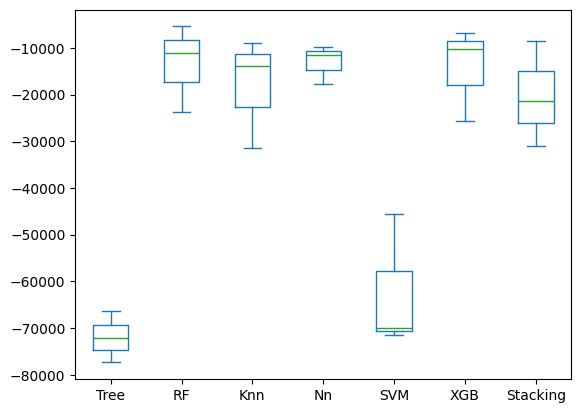

In [60]:
#Resultados de la validación cruzada
comparacion_CV.plot(kind='box')

# Hipótesis

H₀ (nula): No hay diferencia significativa en el desempeño (test_f1) entre los modelos.

H₁ (alternativa): Al menos un modelo tiene un desempeño significativamente diferente.

Se puede usar:
* ANOVA + Tukey
* Friedman + Nemenyi

Nota: Si no existe diferencia estadística significativa se selecciona el modelo por complejidad computacional.

In [61]:
comparacion_CV

,Tree,RF,Knn,Nn,SVM,XGB,Stacking
0,-77363.768,-5424.250,-9029.333,-9723.378,-69927.660,-6820.576,-8455.160
1,-66439.760,-11010.071,-13789.917,-11585.594,-45519.958,-10237.908,-30932.337
2,-72211.591,-23703.339,-31468.075,-17723.293,-71512.505,-25724.583,-21289.037


# ***Análisis de diferencia estadística significativa***

In [62]:
from scipy import stats

# Extraer las columnas de los modelos como grupos
grupos = [comparacion_CV[col].dropna().values for col in comparacion_CV.columns]

anova_result = stats.f_oneway(*grupos)
print("ANOVA:")
print(f"F = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4f}")

if anova_result.pvalue < 0.05:
    print("Hay diferencia estadísticamente significativa entre los modelos (rechazamos H₀).")
else:
    print("No hay diferencia significativa entre los modelos (no se rechaza H₀).")


ANOVA:
F = 18.8594, p-value = 0.0000
Hay diferencia estadísticamente significativa entre los modelos (rechazamos H₀).


In [63]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

# Convertir a formato largo
df_melted = comparacion_CV.melt(var_name='Modelo', value_name='MAPE')

tukey_result = pairwise_tukeyhsd(endog=df_melted['MAPE'], groups=df_melted['Modelo'], alpha=0.05)
print(tukey_result)


        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
 group1   group2    meandiff  p-adj     lower       upper    reject
-------------------------------------------------------------------
     Knn       Nn   5085.0199 0.9951 -23108.8882   33278.928  False
     Knn       RF   4716.5548 0.9967 -23477.3533  32910.4629  False
     Knn      SVM -44224.2661 0.0015 -72418.1742 -16030.3581   True
     Knn Stacking  -2129.7365    1.0 -30323.6446  26064.1716  False
     Knn     Tree -53909.2646 0.0002 -82103.1727 -25715.3565   True
     Knn      XGB   3834.7529  0.999 -24359.1552   32028.661  False
      Nn       RF   -368.4651    1.0 -28562.3732   27825.443  False
      Nn      SVM  -49309.286 0.0005 -77503.1941  -21115.378   True
      Nn Stacking  -7214.7564  0.971 -35408.6645  20979.1517  False
      Nn     Tree -58994.2845 0.0001 -87188.1926 -30800.3764   True
      Nn      XGB   -1250.267    1.0 -29444.1751  26943.6411  False
      RF      SVM  -48940.821 0.0006  -77134.729

Análisis...

Veamos los patrones:

Modelos que fueron significativamente peores según Tukey:

SVM fue significativamente diferente (peor) que:

KNN, NN, RF, XGB, Stacking → (reject = True, meandiff negativo)

Tree también fue significativamente diferente (peor) que:

KNN, NN, RF, Stacking, XGB

Stacking y XGB tienen reject = False entre sí (no difieren significativamente)

KNN, NN, RF, XGB, y Stacking no presentan diferencias significativas entre sí (todos sus pares tienen reject = False).

# ***Hiperparametrización***
En este caso decifimos continuar con estos modelos:

Random Forest (RF)
Stacking
XGBoost (XGB)

In [64]:
#Medida de evaluación del mejor modelo
medidas_CV = pd.DataFrame(index=['MSE'])

In [65]:
from sklearn.model_selection import GridSearchCV

# Crear el modelo base
modelRF = ensemble.RandomForestRegressor(random_state=42)

# Definir los hiperparámetros a evaluar
n_estimators = [50, 100, 200]                # número de árboles
criterion = ['squared_error', 'absolute_error']  # función de pérdida
min_samples_leaf = [2, 10, 50, 100]          # mínimo de registros por hoja
max_depth = [10, 20, 50]                     # profundidad máxima

# Crear la grilla de parámetros
param_grid = dict(
    n_estimators=n_estimators,
    criterion=criterion,
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth
)

# Configurar la búsqueda con validación cruzada
grid = GridSearchCV(
    estimator=modelRF,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5
)

# Entrenar el modelo con todo el dataset (solo CV)
grid.fit(X, Y)

# Guardar el mejor modelo
modelRF = grid.best_estimator_

# Registrar la métrica promedio de validación cruzada
medidas_CV['RandomForest'] = grid.best_score_

# Mostrar resultados
print("Mejores parámetros:", grid.best_params_)
print("Medidas de validación cruzada:", medidas_CV)

Mejores parámetros: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Medidas de validación cruzada:       RandomForest
MSE -324986274.497


In [83]:
# Stacking Regressor usando from sklearn import ensemble
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Modelos base
base_learners = [
    ('tree', ensemble.RandomForestRegressor(random_state=42)),
    ('rf', ensemble.GradientBoostingRegressor(random_state=42))
]

# Meta-modelo (modelo final)
meta_model = LinearRegression()

# Crear el modelo base de stacking
modelStacking = ensemble.StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_model,
    n_jobs=-1
)

# Definir los hiperparámetros a evaluar
param_grid = {
    'final_estimator': [LinearRegression(), SVR()],
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [10, 20],
    'tree__n_estimators': [50, 100],
    'tree__max_depth': [10, 20]
}

# Configurar la búsqueda con validación cruzada
grid = GridSearchCV(
    estimator=modelStacking,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5
)

# Entrenar el modelo con todo el dataset
grid.fit(X, Y)

# Mejor modelo
modelStacking = grid.best_estimator_

# Guardar la métrica promedio de validación cruzada
medidas_CV['Stacking'] = grid.best_score_

# Mostrar resultados
print("Mejores parámetros:", grid.best_params_)
print("Medidas de validación cruzada:", medidas_CV)


Mejores parámetros: {'final_estimator': LinearRegression(), 'rf__max_depth': 10, 'rf__n_estimators': 100, 'tree__max_depth': 20, 'tree__n_estimators': 50}
Medidas de validación cruzada:      RandomForest      Stacking           XGB
MSE -324986274.50 -598420220.74 -301834470.34


In [84]:
#  XGBoost Regressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Crear el modelo base
modelXGB = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Definir los hiperparámetros a evaluar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# Configurar la búsqueda con validación cruzada
grid = GridSearchCV(
    estimator=modelXGB,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5,
    verbose=1
)

# Entrenar el modelo con todo el dataset
grid.fit(X, Y)

# Guardar el mejor modelo
modelXGB = grid.best_estimator_

# Registrar la métrica promedio de validación cruzada
medidas_CV['XGB'] = grid.best_score_

# Mostrar resultados
print(" Mejores parámetros:", grid.best_params_)
print(" Medidas de validación cruzada:", medidas_CV)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
 Mejores parámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
 Medidas de validación cruzada:      RandomForest      Stacking           XGB
MSE -324986274.50 -598420220.74 -301834470.34


In [68]:
pd.set_option('display.float_format', '{:.2f}'.format)
medidas_CV.round(1)

,RandomForest,Stacking,XGB
MSE,-324986274.50,-598420220.70,-301834470.30


# Proyección a despliegue...

División 70-30

In [69]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["energyproducedtoday"])
Y = df["energyproducedtoday"]

X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

In [70]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Inicializamos escalador y PCA
scaler = MinMaxScaler()
pca = PCA(n_components=3)

# --- (1) Con normalización y con PCA ---
X_train_si_norm_si_PCA = pca.fit_transform(scaler.fit_transform(X_train_raw))
X_test_si_norm_si_PCA = pca.transform(scaler.transform(X_test_raw))

# --- (2) Con normalización y sin PCA ---
X_train_si_norm_no_PCA = scaler.fit_transform(X_train_raw)
X_test_si_norm_no_PCA = scaler.transform(X_test_raw)

# --- (3) Sin normalización y con PCA ---
X_train_no_norm_si_PCA = pca.fit_transform(X_train_raw)
X_test_no_norm_si_PCA = pca.transform(X_test_raw)

# --- (4) Sin normalización y sin PCA ---
X_train_no_norm_no_PCA = X_train_raw.copy()
X_test_no_norm_no_PCA = X_test_raw.copy()

Random Forest

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
# Modelo
modelRf = ensemble.RandomForestRegressor(n_estimators=200, max_samples=0.8, criterion='squared_error', min_samples_leaf=7, max_depth=None)

# Entrenamiento con el 70%
modelRf.fit(X_train_no_norm_no_PCA, Y_train)

# Predicción con el 30%
Y_pred = modelRf.predict(X_test_no_norm_no_PCA)

# Métricas
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)
mape = mean_absolute_percentage_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

# Resultados en un DataFrame
resultados_tree = pd.DataFrame({
    'MSE': [mse],
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE': [mape],
    'R2': [r2]
})

print(resultados_tree)

          MSE    RMSE     MAE  MAPE   R2
0 92915148.51 9639.25 6889.75  0.11 0.94


este modelo da excelente y es el que llevaremos a despliegue

# Pipeline
al ser datos de sensores, solo esperamos hacer imputación por si hay algún valor faltante.

In [72]:
# Definir columnas categóricas
categorical_cols = [] #No hay

# Todas las demás columnas son numéricas
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Para variables numéricas: Imputar por media y normalizar
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Para variables categóricas: imputar por moda y crear dummies
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('dummies', OneHotEncoder(drop='if_binary',handle_unknown='ignore', sparse_output=False))
])

# Unir los dos pasos anteriores
missing_transformations = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
])

In [74]:
# Definir el pipeline

pipe = Pipeline(steps=[
    ('preprocessor', missing_transformations)
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Outdoor Temperature '
                                                   '(Â°C)_max',
                                                   'Outdoor Temperature '
                                                   '(Â°C)_min',
                                                   'Feels Like (Â°C)_max',
                                                   'Feels Like (Â°C)_min',
                                                   'Dew Point (Â°C)_max',
                                                   'Dew Point (Â°C)_min',
                                                   'Wind Speed (m/sec)_max',
                                                   'Wind Gust (m/sec)_max',
                                                   'Max Daily Gust (m...
                                                   'Indoor Temperature '
                                                   '(Â°C)_max',
                                                   'Indoor Temperature '
                                                   '(Â°C)_min',
                                                   'Indoor Humidity (%)_max',
                                                   'Indoor Humidity (%)_min',
                                                   'Avg Wind Direction (10 '
                                                   'mins) (Â°)_min',
                                                   'capacity_45kw',
                                                   'capacity_52kw']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('dummies',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])]))])

In [75]:
#Aplicar el pipe a los datos
X_processed = pipe.fit_transform(X)
X_processed

array([[0.61538462, 0.59574468, 0.66666667, ..., 0.30555556, 1.        ,
        0.        ],
       [0.76923077, 0.36170213, 0.78666667, ..., 0.125     , 1.        ,
        0.        ],
       [0.66666667, 0.57446809, 0.65333333, ..., 0.16666667, 1.        ,
        0.        ],
       ...,
       [0.33333333, 0.14893617, 0.49333333, ..., 0.19444444, 0.        ,
        1.        ],
       [0.43589744, 0.17021277, 0.46666667, ..., 0.16666667, 0.        ,
        1.        ],
       [0.41025641, 0.36170213, 0.49333333, ..., 0.83333333, 0.        ,
        1.        ]])

Modelo final

In [76]:
# Reentrenar el modelo con todos los datos
modelRf.fit(X_processed, Y)

RandomForestRegressor(max_samples=0.8, min_samples_leaf=7, n_estimators=200)

In [77]:
# Crea el pipeline con el escalado, codificación y modelo

from sklearn.pipeline import Pipeline


pipeline_model = Pipeline([
    ('preprocessor', pipe),  # Aplica el preprocesamiento
    ('model', modelRf)  # Modelo de red neuronal
])
pipeline_model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['Outdoor '
                                                                    'Temperature '
                                                                    '(Â°C)_max',
                                                                    'Outdoor '
                                                                    'Temperature '
                                                                    '(Â°C)_min',
                                                                    'Feels '
                                                                    'Like '
                                                                    '(Â°C)_max',
                                                                    'Feels '
                                                                    'Like '
                                                                    '(Â°C)_min',
                                                                    'Dew Point '
                                                                    '(Â°C)_max',
                                                                    'Dew Point '
                                                                    '(Â°C)_min',
                                                                    'Wind '
                                                                    'Speed...
                                                                    'Humidity '
                                                                    '(%)_min',
                                                                    'Avg Wind '
                                                                    'Direction '
                                                                    '(10 mins) '
                                                                    '(Â°)_min',
                                                                    'capacity_45kw',
                                                                    'capacity_52kw']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('dummies',
                                                                                    OneHotEncoder(drop='if_binary',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   [])]))])),
                ('model',
                 RandomForestRegressor(max_samples=0.8, min_samples_leaf=7,
                                       n_estimators=200))])

Guardamos el modelo

In [78]:
#Se guarda el pipeline
import pickle
filename = 'pipeline_modelo.pkl'
pickle.dump(pipeline_model, open(filename, 'wb'))

In [79]:
print("Columnas del dataset:", list(X.columns))
print("\nTipos de datos:")
print(X.dtypes)

Columnas del dataset: ['Outdoor Temperature (Â°C)_max', 'Outdoor Temperature (Â°C)_min', 'Feels Like (Â°C)_max', 'Feels Like (Â°C)_min', 'Dew Point (Â°C)_max', 'Dew Point (Â°C)_min', 'Wind Speed (m/sec)_max', 'Wind Gust (m/sec)_max', 'Max Daily Gust (m/sec)_max', 'Wind Direction (Â°)_max', 'Wind Direction (Â°)_min', 'Rain Rate (mm/hr)_max', 'Daily Rain (mm)_max', 'Weekly Rain (mm)_max', 'Weekly Rain (mm)_min', 'Yearly Rain (mm)_max', 'Yearly Rain (mm)_min', 'Humidity (%)_min', 'Ultra-Violet Radiation Index_max', 'Solar Radiation (W/m^2)_max', 'Indoor Temperature (Â°C)_max', 'Indoor Temperature (Â°C)_min', 'Indoor Humidity (%)_max', 'Indoor Humidity (%)_min', 'Avg Wind Direction (10 mins) (Â°)_min', 'capacity_45kw', 'capacity_52kw']

Tipos de datos:
Outdoor Temperature (Â°C)_max            float64
Outdoor Temperature (Â°C)_min            float64
Feels Like (Â°C)_max                     float64
Feels Like (Â°C)_min                     float64
Dew Point (Â°C)_max                      floa

In [80]:
print(pipeline_model.feature_names_in_)

['Outdoor Temperature (Â°C)_max' 'Outdoor Temperature (Â°C)_min'
 'Feels Like (Â°C)_max' 'Feels Like (Â°C)_min' 'Dew Point (Â°C)_max'
 'Dew Point (Â°C)_min' 'Wind Speed (m/sec)_max' 'Wind Gust (m/sec)_max'
 'Max Daily Gust (m/sec)_max' 'Wind Direction (Â°)_max'
 'Wind Direction (Â°)_min' 'Rain Rate (mm/hr)_max' 'Daily Rain (mm)_max'
 'Weekly Rain (mm)_max' 'Weekly Rain (mm)_min' 'Yearly Rain (mm)_max'
 'Yearly Rain (mm)_min' 'Humidity (%)_min'
 'Ultra-Violet Radiation Index_max' 'Solar Radiation (W/m^2)_max'
 'Indoor Temperature (Â°C)_max' 'Indoor Temperature (Â°C)_min'
 'Indoor Humidity (%)_max' 'Indoor Humidity (%)_min'
 'Avg Wind Direction (10 mins) (Â°)_min' 'capacity_45kw' 'capacity_52kw']


In [81]:
import pandas as pd

# Columnas esperadas por el pipeline
cols = [
    'Outdoor Temperature (Â°C)_max', 'Outdoor Temperature (Â°C)_min',
    'Feels Like (Â°C)_max', 'Feels Like (Â°C)_min',
    'Dew Point (Â°C)_max', 'Dew Point (Â°C)_min',
    'Wind Speed (m/sec)_max', 'Wind Gust (m/sec)_max',
    'Max Daily Gust (m/sec)_max', 'Wind Direction (Â°)_max',
    'Wind Direction (Â°)_min', 'Rain Rate (mm/hr)_max', 'Daily Rain (mm)_max',
    'Weekly Rain (mm)_max', 'Weekly Rain (mm)_min', 'Yearly Rain (mm)_max',
    'Yearly Rain (mm)_min', 'Humidity (%)_min',
    'Ultra-Violet Radiation Index_max', 'Solar Radiation (W/m^2)_max',
    'Indoor Temperature (Â°C)_max', 'Indoor Temperature (Â°C)_min',
    'Indoor Humidity (%)_max', 'Indoor Humidity (%)_min',
    'Avg Wind Direction (10 mins) (Â°)_min', 'capacity_45kw', 'capacity_52kw'
]

# Crear DataFrame con valores por defecto (0.0)
data_sintetico = pd.DataFrame([{col: 0.0 for col in cols}])

# Convertir las columnas binarias a enteros (por claridad)
data_sintetico['capacity_45kw'] = 0
data_sintetico['capacity_52kw'] = 0

# Exportar a Excel
nombre_archivo = "datos_sinteticos.xlsx"
data_sintetico.to_excel(nombre_archivo, index=False)

print(f"Archivo Excel creado exitosamente: {nombre_archivo}")

Archivo Excel creado exitosamente: datos_sinteticos.xlsx
